In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from env import get_db_url

In [9]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

df = pd.read_sql('SELECT * FROM api_access', get_db_url('logs'))
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [10]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

#### IP Address

In [11]:
ip_df = value_counts_and_frequencies(df.ip)

<AxesSubplot:>

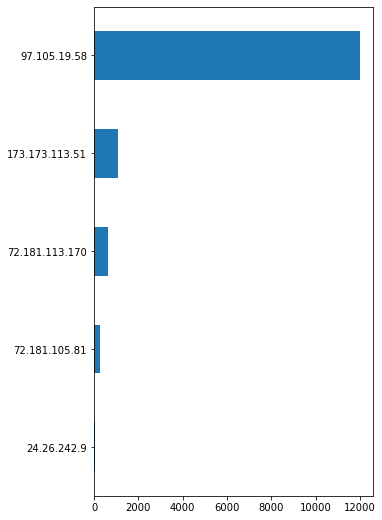

In [12]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


#### Status by IP Address

In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [14]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


#### Examining request method and http version

In [15]:
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

In [16]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

Considering request method and http version only have one value no need to explore these further. If had anything other than these values it would be anomalous

#### Time - day of the week and hour of the day

In [17]:
df.timestamp = pd.to_datetime(df.timestamp)

In [18]:
df.groupby(df.timestamp.dt.day_name()).status_code.value_counts(normalize=True)

timestamp  status_code
Tuesday    200            0.998828
           499            0.001172
Wednesday  200            0.999013
           499            0.000987
Name: status_code, dtype: float64

In [29]:
pd.DataFrame(df.groupby(df.timestamp.dt.day_name()).user_agent.value_counts(normalize=True))

user_agent
timestamp user_agent                                                    
Tuesday   python-requests/2.21.0                                0.836026
          python-requests/2.20.1                                0.159956
          Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4)...    0.002846
          Slackbot-LinkExpanding 1.0 (+https://api.slack....    0.000502
          Slackbot 1.0 (+https://api.slack.com/robots)          0.000419
          Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)...    0.000167
          Python-urllib/3.7                                     0.000084
Wednesday python-requests/2.21.0                                0.993093
          Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; r...    0.003947
          Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)...    0.000987
          Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)...    0.000987
          Slackbot 1.0 (+https://api.slack.com/robots)          0.000493
          Slackbot-LinkExpanding 1.0 (+https://api.slack....    0.000493

Day of the week and status codes - appear to show about the same probability of 499 for both days. Grouping by day of the week and looking at the other features do not show anything remarkable, though for user_agent it would be very rare on Wednesdays to see something other than python-requests/2.21.0.

In [30]:
df.timestamp.dt.hour.value_counts(normalize=True)

20    0.328252
21    0.245456
19    0.160584
22    0.120510
3     0.057750
1     0.027193
2     0.020323
5     0.018105
4     0.014956
12    0.005009
6     0.001073
0     0.000572
23    0.000143
10    0.000072
Name: timestamp, dtype: float64

In [21]:
df.timestamp.dt.hour.value_counts(normalize=True).head(4).sum()

0.8548017747244884

Over 85% of timestamps are from the hours 19-22

When are we getting these suspicious 499 requests?

In [54]:
df[df.status_code=='499'].groupby(df.timestamp.dt.hour).size()

timestamp
2     1
3     1
19    2
20    7
21    4
22    1
dtype: int64

Most are coming in 19-22, two 2-3

In [22]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

499 codes appear to be anomolous - are these linked with other features?

Text(0, 0.5, 'Percentage')

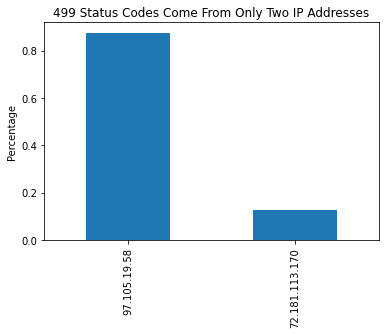

In [33]:
df[df.status_code=='499'].ip.value_counts(normalize=True).plot.bar()
plt.title('499 Status Codes Come From Only Two IP Addresses')
plt.ylabel('Percentage')

In [24]:
df[df.status_code=='499'].request_path.value_counts()

/api/v1/items             4
/api/v1/sales?page=2      3
/api/v1/sales?page=21     1
/api/v1/sales?page=29     1
/api/v1/sales?page=115    1
/api/v1/sales?page=47     1
/api/v1/sales?page=25     1
/api/v1/sales?page=80     1
/api/v1/sales?page=69     1
/api/v1/sales?page=8      1
/api/v1/sales?page=133    1
Name: request_path, dtype: int64

The 499s come from only 2 IP addresses. Nearly 90% from 97.105.19.58, which is the most common IP address by far in the dataset. Independent of request path - all over sales pages and items.

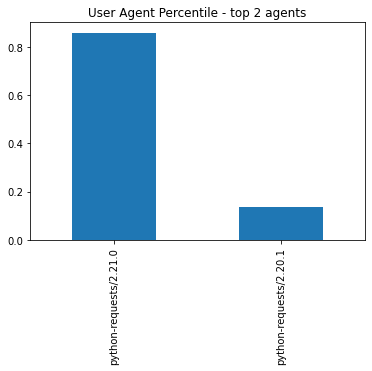

In [25]:
df.user_agent.value_counts(normalize=True).head(2).plot.bar()
plt.title('User Agent Percentile - top 2 agents')
None

In [37]:
pd.DataFrame(df.groupby('user_agent').status_code.value_counts(normalize=True).rename('proba_status_given_ua'))

proba_status_given_ua
user_agent                                         status_code                       
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; r... 200                       1.000000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)... 200                       1.000000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3)... 200                       1.000000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4)... 200                       1.000000
Python-urllib/3.7                                  200                       1.000000
Slackbot 1.0 (+https://api.slack.com/robots)       200                       1.000000
Slackbot-LinkExpanding 1.0 (+https://api.slack.... 200                       1.000000
python-requests/2.20.1                             200                       0.997907
                                                   499                       0.002093
python-requests/2.21.0                             200                       0.999000
                                                   499                       0.001000

Only expect 499s to come from python-requests. Even from python-requests it is very low probability.

Text(0.5, 1.0, 'Size of Request Binned')

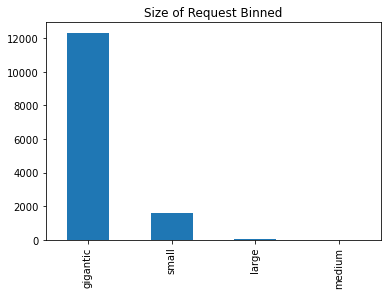

In [27]:
pd.cut(df['size'],4, labels=['small','medium','large','gigantic']).value_counts().plot.bar()
plt.title('Size of Request Binned')

In [39]:
df['size_bin'] = pd.cut(df['size'],4, labels=['small','medium','large','gigantic'])

In [45]:
pd.DataFrame(df.groupby('size_bin').status_code.value_counts(normalize=True).rename('proba_status_given_size'))

proba_status_given_size
size_bin status_code                         
small    200                         0.989893
         499                         0.010107
medium   200                         1.000000
large    200                         1.000000
gigantic 200                         1.000000

Would only expect a 499 from a small size

### Based on the results of exploration:
- 499s are quite rare status codes
- 499s only expected from python-requests user agent
- Would only expect 499s from small size and from only two IP addresses
- Timing on the 499s is consistent with when most requests come in (19-22)
- 499s seem to be independent of request path, though api/items is most common